### Section 1: Initial settings 

#### 1.1 Importing

In [1]:
import rebound 

import sympy as sp
from matplotlib import pyplot as plt
from matplotlib import pyplot

import numpy as np
from numpy import cos, sin

from sympy import init_printing
init_printing()

%matplotlib inline

# plot style and colour
plt.style.use('seaborn')
plt.rcParams['axes.facecolor'] = 'whitesmoke'

# plot border
plt.rcParams["axes.edgecolor"] = '0'
plt.rcParams["axes.linewidth"] = 0.7

#### 1.2 Conversion and time 

In [2]:
rad_mas = 206264806
rad_as  = 206264806/1000
as_mas  = 1000
AU_pc   = 4.84814e-6

timescale = 4.2
m         = 200
times     = np.linspace(0,timescale,num = m)

## Section 2: Functions

#### 2.1 Function called $simple\_function$ that creates simulation with and without planet from initial conditions

In [3]:
def get_simulation(m_star = 1, vy_star = 2.498, vz_star=4.247, z_star = 50*206265, m_planet=0.0143188, inc=0, a_AU=0.6, e=0.2):
    # with planet 
    sim_wp = rebound.Simulation()                                                        # create a simulation named sim_wp 

    sim_wp.units = ["msun","AU","year"]                                                  # setting units of sim_wpm

    sim_wp.add(m = 1)                                                                    # add the Sun as the central object 

    sim_wp.add(m = 3.0027e-6, a = 1, e = 0)                                              # add Earth in a 1 AU circular orbit 
    
    sim_wp.add(x = 1.031e7, vy = vy_star, m = m_star, z = z_star, vz = vz_star)          # add a star 50 pc away with calculated velocity and set parameters

    sim_wp.add(m = m_planet, a = a_AU, e = e, primary = sim_wp.particles[2], inc = inc)  # add planet from figure 3.1 caption and have it orbit the star 
    
    # barycentre particles
    com_particle  = sim_wp.calculate_com(first = 2,last = 4)
    ssbc_particle = sim_wp.calculate_com(first = 0,last = 2)
    
    # without planet
    sim = rebound.Simulation()                                                           # create a simulation named sim 

    sim.units = ["msun","AU","year"]                                                     # setting units of sim 

    sim.add(m = 1)                                                                       # add the Sun as the central object 

    sim.add(m = 3.0027e-6, a = 1, e = 0)                                                 # add Earth in a 1 AU circular orbit 

    sim.add(com_particle)                                                                # add a particle equivaent to the star-planet barycentre
    
    return(sim_wp, sim)

#### 2.2 Function called $simple\_function$ that returns $d, \delta$ and $\alpha$ from the positions $R=R_x, R_y, R_z$

In [15]:
def simple_function(R):
    Rx, Ry, Rz = R
    
    rho = np.sqrt(Rx**2+Ry**2)
    
    d      = np.linalg.norm(R, axis=0)
    delta  = np.arctan2(Rz, rho)
    alpha  = np.arctan2(Ry, Rx)
    
    return(d, delta,alpha)

#### 2.3 function called $simulation\_function$ that returns $\delta$ and $\alpha$ for two vectors $r\_SE=r\_star - r\_earth$ and $r\_SC=r\_star-r\_ssbc$ as well as $r\_SC_0$ and $V\_SC_0$ for $equations\_function$

In [16]:
def simulation_function(sim, times):
    r_star = np.zeros((m,3))
    r_ssbc = np.zeros((m,3))
    r_earth = np.zeros((m,3))
    
    R_SE = np.zeros((m,3))
    R_SC = np.zeros((m,3))
    
    delta_SE = np.zeros(m)
    alpha_SE = np.zeros(m)
    delta_SC = np.zeros(m)
    alpha_SC = np.zeros(m)
    
    v_star = np.zeros((m,3))
    v_ssbc = np.zeros((m,3))
    
    for i,t in enumerate(times):
        sim.integrate(t)
        sim_wp.integrate(t)
        
        star_particle = sim.particles[2]
        ssbc_particle = sim.calculate_com(first = 0,last = 2)
        earth_particle = sim.particles[1]
        
        r_star[i] = np.array(star_particle.xyz)
        r_ssbc[i] = np.array(ssbc_particle.xyz)
        r_earth[i]= np.array(earth_particle.xyz)
    
        R_SE[i] = r_star[i] - r_earth[i]
        R_SC[i] = r_star[i] - r_ssbc[i]
    
        _, delta_SE[i], alpha_SE[i] = simple_function(R_SE[i])
        _, delta_SC[i], alpha_SC[i] = simple_function(R_SC[i])
        
        v_star[i] = np.array(star_particle.vxyz)
        v_ssbc[i] = np.array(ssbc_particle.vxyz)
        
        V0 = v_star[0] - v_ssbc[0]
        R0 = r_star[0] - r_earth[0]
    
    return(delta_SE, alpha_SE, delta_SC, alpha_SC, R0, V0)

#### 2.4 Function called $equations\_function$ that uses the initial positions of $r\_SE$ and its the initial velocity found from  $simulation\_function$ to find the proper motion and parallax terms as well as the total signal

In [6]:
def equations_function(R0, V0, times, t0=0, a_earth = 1):
    d_0, delta_0, alpha_0 = simple_function(R0)
    
    Vx_0, Vy_0, Vz_0 = V0 
    
    sind, cosd, sina, cosa  = sin(delta_0), cos(delta_0), sin(alpha_0), cos(alpha_0)
    
    d_dot_0     =   Vx_0 * cosa * cosd        +  Vy_0 * sina * cosd       +  Vz_0 * sind
    delta_dot_0 = -(Vx_0 * sind * cosa)/d_0   - (Vy_0 * sina * sind)/d_0  + (Vz_0 * cosd)/d_0
    alpha_dot_0 = -(Vx_0 * sina)/(d_0 * cosd) + (Vy_0 * cosa)/(d_0*cosd)
    
    T = times - t0    

    proper_motion_term_dec = delta_dot_0*T
    proper_motion_term_ra  = alpha_dot_0*T
    
    parallax_term_dec = (a_earth/d_0)*sin(delta_0)*cos(2*np.pi*T-alpha_0)
    parallax_term_ra  = (a_earth/(d_0*cos(delta_0)))*(sin(alpha_0)*cos(2*np.pi*T)-cos(alpha_0)*sin(2*np.pi*T))
    
    signal_dec = proper_motion_term_dec + parallax_term_dec 
    signal_ra = proper_motion_term_ra + parallax_term_ra 
    
    return (proper_motion_term_dec, proper_motion_term_ra, parallax_term_dec, parallax_term_ra,signal_dec, signal_ra)

## Section 3: Using functions

#### 3.1 Simulation

In [7]:
# start simulations 
sim_wp, sim = get_simulation()

# simulation without planet
sim_values = simulation_function(sim, times)
delta_SE_np, alpha_SE_np, delta_SC_np, alpha_SC_np, R0_np, V0_np = sim_values

# simulation with planet
sim_wp_values = simulation_function(sim_wp, times)
delta_SE_wp, alpha_SE_wp, delta_SC_wp, alpha_SC_wp, R0_wp, V0_wp = sim_wp_values

#### 3.2 Equations

In [8]:
# star_particle = sim.particles[2]
# ssbc_particle = sim.calculate_com(first = 0,last = 2)

# r_star = np.array(star_particle.xyz)
# v_star = np.array(star_particle.vxyz)

# r_ssbc = np.array(ssbc_particle.xyz)
# v_ssbc = np.array(ssbc_particle.vxyz)

# R0 = r_star - r_ssbc
# V0 = v_star - v_ssbc

In [9]:
function = equations_function(R0_np, V0_np, times)
proper_motion_term_dec, proper_motion_term_ra, parallax_term_dec, parallax_term_ra,signal_dec, signal_ra = function

## Section 4: Plots

#### 4.1 Signal from simulation

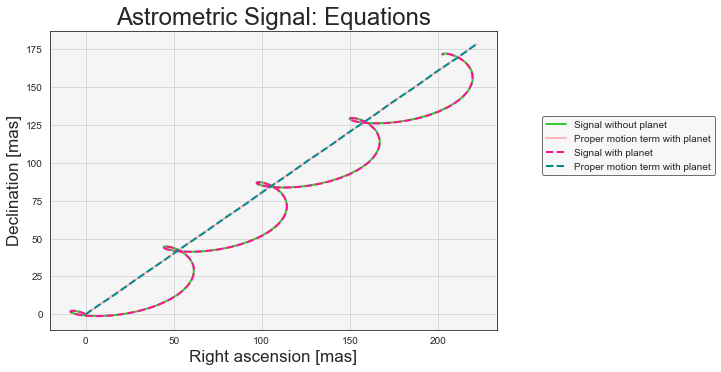

In [17]:
# plotting data 
plt.plot((alpha_SE_np)*rad_mas, 
         (delta_SE_np-delta_SE_np[0])*rad_mas, 
         color='limegreen', 
         lw=2,           
         label = 'Signal without planet')

plt.plot((alpha_SC_np-alpha_SC_np[0])*rad_mas, 
         (delta_SC_np-delta_SC_np[0])*rad_mas, 
         color='lightpink', 
         lw=2, 
         label = 'Proper motion term with planet')

plt.plot((alpha_SE_wp)*rad_mas, 
        (delta_SE_wp-delta_SE_wp[0])*rad_mas, 
         color='deeppink', 
         lw=2, 
         ls='--', 
         label = 'Signal with planet')

plt.plot((alpha_SC_wp-alpha_SC_wp[0])*rad_mas, 
         (delta_SC_wp-delta_SC_wp[0])*rad_mas, 
         color='darkcyan', 
         lw=2, 
         ls='--', 
         label = 'Proper motion term with planet')

# set titles 
plt.title('Astrometric Signal: Equations', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.2 Diffference in simulation signals  

##### 4.2.1 $r\_SE$

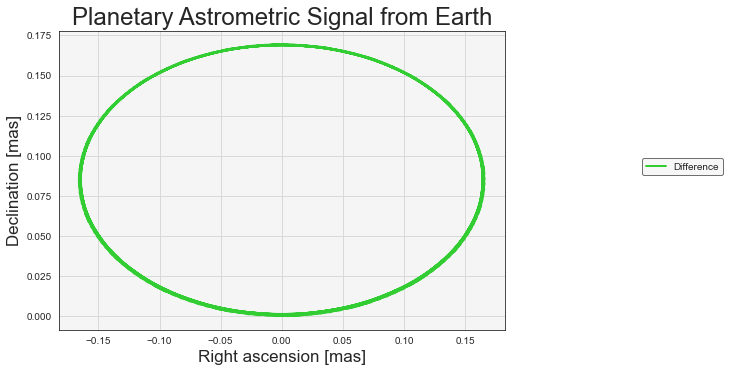

In [21]:
# plotting data 

ra_diff = alpha_SE_np - alpha_SE_wp

dec_diff = (delta_SE_np-delta_SE_np[0]) - (delta_SE_wp-delta_SE_wp[0])

plt.plot(ra_diff*rad_mas, 
         dec_diff*rad_mas, 
         color='limegreen', 
         lw=2,           
         label = 'Difference')




# set titles 
plt.title('Planetary Astrometric Signal from Earth', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

##### 4.2.2 $r\_SC$

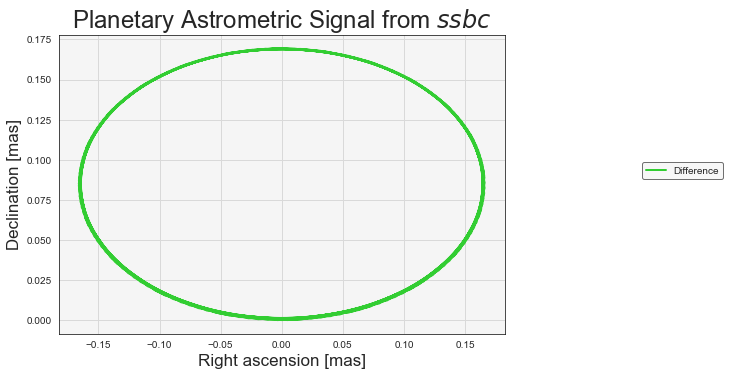

In [19]:
# plotting data 
ra_diff_SC = alpha_SC_np - alpha_SC_wp

dec_diff_SC = (delta_SC_np-delta_SC_np[0]) - (delta_SC_wp-delta_SC_wp[0])

plt.plot(ra_diff_SC*rad_mas, 
         dec_diff_SC*rad_mas, 
         color='limegreen', 
         lw=2,           
         label = 'Difference')

# set titles 
plt.title('Planetary Astrometric Signal from $ssbc$', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.3 Equations plot

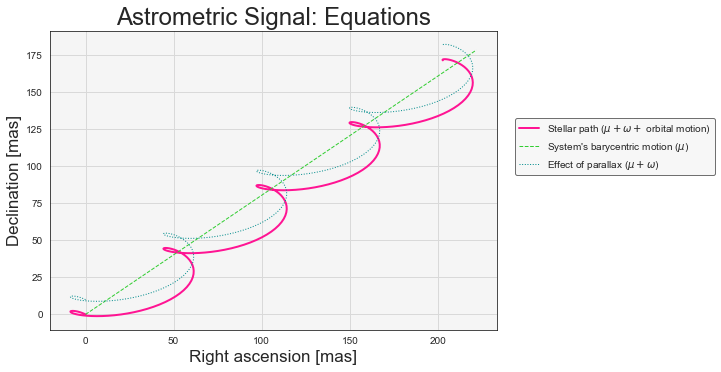

In [13]:
# plotting data 
plt.plot(signal_ra*rad_mas, 
         (signal_dec-signal_dec[0])*rad_mas, 
         color='deeppink', 
         lw=2,
         label = 'Stellar path ($\mu + \omega +$ orbital motion)')

plt.plot(proper_motion_term_ra*rad_mas, 
         proper_motion_term_dec*rad_mas, 
         color='limegreen', 
         lw=1,           
         ls='--', 
         label = 'System\'s barycentric motion ($\mu$)')

plt.plot((proper_motion_term_ra+parallax_term_ra)*rad_mas, 
         (proper_motion_term_dec+parallax_term_dec)*rad_mas, 
         color='darkcyan', 
         lw=1, 
         ls='dotted', 
         label = 'Effect of parallax ($\mu + \omega $)')

# set titles 
plt.title('Astrometric Signal: Equations', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

####  4.4 Comparing simulation with planet and equation

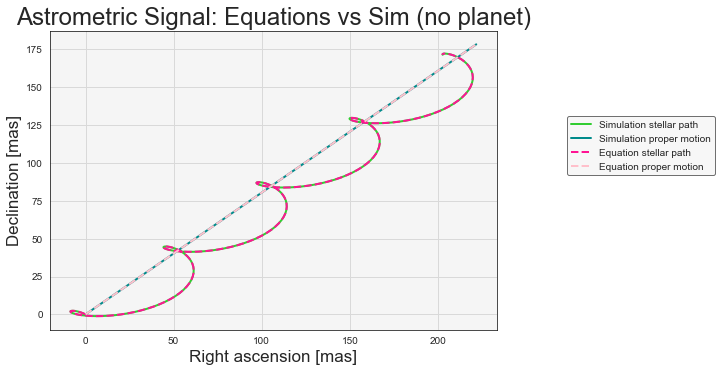

In [14]:
# plotting data 
plt.plot((alpha_SE_np)*rad_mas, 
        (delta_SE_np-delta_SE_np[0])*rad_mas, 
         color='limegreen', 
         lw=2, 
         label = 'Simulation stellar path')

plt.plot((alpha_SC_np-alpha_SC_np[0])*rad_mas, 
         (delta_SC_np-delta_SC_np[0])*rad_mas, 
         color='darkcyan', 
         lw=2, 
         label = 'Simulation proper motion')


plt.plot(signal_ra*rad_mas, 
         (signal_dec-signal_dec[0])*rad_mas, 
         color='deeppink', 
         lw=2,
         ls='--', 
         label = 'Equation stellar path')

plt.plot(proper_motion_term_ra*rad_mas, 
         proper_motion_term_dec*rad_mas, 
         color='pink', 
         lw=2,           
         ls='--', 
         label = 'Equation proper motion')

# set titles 
plt.title('Astrometric Signal: Equations vs Sim (no planet)', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)